In [1]:
import sys
sys.path.append('../../')
from analytical.analytical import VMD

import numpy as np
import matplotlib.pyplot as plt
import empymod
import emulatte.forward as fwd

In [2]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.array([x if x > 0 else np.nan for x in data])


def neg(data):
    """Return -negative data; set positive data to NaN."""
    return np.array([-x if x < 0 else np.nan for x in data])


def calc_rel_err(ans_num, ans_ana):
    rel_err = np.abs((ans_num - ans_ana) / ans_ana) * 100
    return rel_err

In [3]:
# 探査条件
# Survey parameters
freq = np.logspace(-1, 5, 301)

# 送受信点位置 [x,y,z,phi,theta] 直交座標系および極座標系(方位角と仰角(dip)) 左手系
# 送受信点は地表面
src = [0, 0, 0, 0, 90]
rec = [100, 0, 0, 0, 90]

# 均質構造
depth = 0
res = [2e14, 100]  # 空気層の比抵抗を無限大と近似
# 探査条件の格納 (for empymod)
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': freq, 'verb': 1}

# 解析解
vmd = VMD()
r = np.sqrt(rec[0]**2 + rec[1]**2)  # 送受信器間距離
fhz_ana = vmd.fd_hz(res[1], r, freq)

# empymod
fhz_emp = empymod.loop(**inp)

# emulatte
# VMD
emsrc_name = 'VMD'
# 層厚
thick = []
# 地下の物性値
props = {'res': res}
# 物理空間モデルの呼び出し
model = fwd.model(thick)
# 物性値の割り当て
model.set_properties(**props)
# 送信ソースの呼び出しと設定
emsrc = fwd.transmitter(emsrc_name, freq, moment=1)
# 送信ソースの設置と受信座標の設定
model.locate(emsrc, src[:3], rec[:3])
# 電磁応答の取得
EMF = model.emulate(hankel_filter='werthmuller201')

# 成分抽出
fhz_emu = EMF['h_z']

# 相対誤差
rel_err_emp_re = calc_rel_err(fhz_ana.real, fhz_emp.real)
rel_err_emp_im = calc_rel_err(fhz_ana.imag, fhz_emp.imag)
rel_err_emu_re = calc_rel_err(fhz_ana.real, fhz_emu.real)
rel_err_emu_im = calc_rel_err(fhz_ana.imag, fhz_emu.imag)

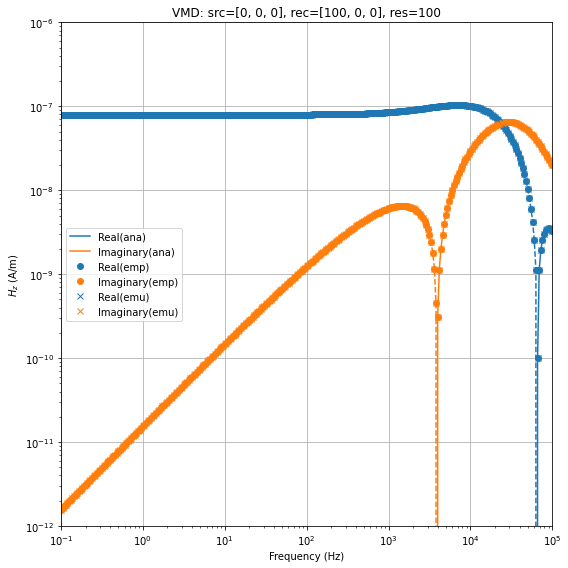

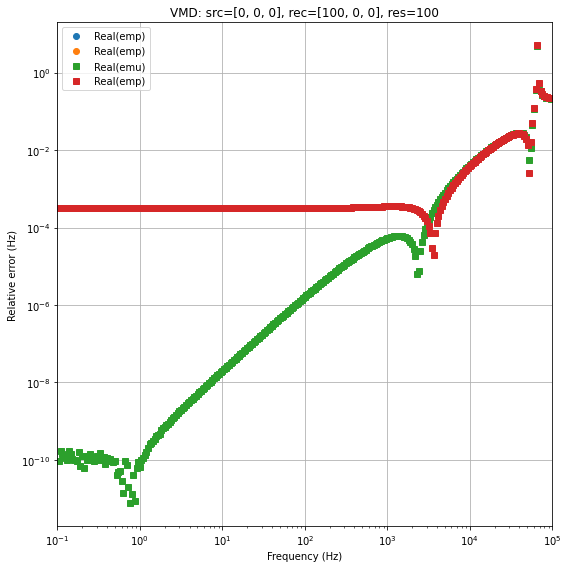

In [4]:
plt.figure(figsize=(8, 8))
plt.title(f'{emsrc_name}: src={src[:3]}, rec={rec[:3]}, res={res[1]}')

plt.plot(freq, fhz_ana.real, 'C0-', label='Real(ana)')
plt.plot(freq, -fhz_ana.real, 'C0--')
plt.plot(freq, fhz_ana.imag, 'C1-', label='Imaginary(ana)')
plt.plot(freq, -fhz_ana.imag, 'C1--')

plt.plot(freq, pos(fhz_emp.real), 'C0o', label='Real(emp)')
plt.plot(freq, neg(fhz_emp.real), 'C0o')
plt.plot(freq, pos(fhz_emp.imag), 'C1o', label='Imaginary(emp)')
plt.plot(freq, neg(fhz_emp.imag), 'C1o')

plt.plot(freq, pos(fhz_emu.real), 'C0x', label='Real(emu)')
plt.plot(freq, neg(fhz_emu.real), 'C0x')
plt.plot(freq, pos(fhz_emu.imag), 'C1x', label='Imaginary(emu)')
plt.plot(freq, neg(fhz_emu.imag), 'C1x')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1, 1e5])
plt.ylim([1e-12, 1e-6])
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$H_z$ (A/m)')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8, 8))
plt.title(f'{emsrc_name}: src={src[:3]}, rec={rec[:3]}, res={res[1]}')

plt.plot(freq, rel_err_emp_re, 'o',label='Real(emp)')
plt.plot(freq, rel_err_emp_re, 'o',label='Real(emp)')
plt.plot(freq, rel_err_emu_re, 's',label='Real(emu)')
plt.plot(freq, rel_err_emp_re, 's',label='Real(emp)')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1, 1e5])
# plt.ylim([1e-12, 1e-6])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative error (Hz)')
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.show()

In [5]:
# 探査条件
time = np.logspace(-8, 0, 301)
# 送受信点位置
src = [0, 0, 0, 0, 90]
rec = [100, 0, 0, 0, 90]
# 均質構造
depth = 0
thick = []
res = [2e14, 100]  # 空気層の比抵抗を無限大と近似
epermH = [0, 1]
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res, 'verb': 1, 'xdirect': True, 'epermH': epermH}

# emulatte
# VMD
emsrc_name = 'VMD'
props = {'res': res}
model = fwd.model(thick)
model.set_properties(**props)
emsrc = fwd.transmitter(emsrc_name, time, moment=1)
model.locate(emsrc, src[:3], rec[:3])
# FFT
EMF = model.emulate(hankel_filter='werthmuller201', td_transform='FFT', time_diff=False)
thz_emu = EMF['h_z'].real
EMF_dt = model.emulate(hankel_filter='werthmuller201', td_transform='FFT', time_diff=True)
thzdt_emu = EMF_dt['h_z'].real

# DLAG (出力2つ)
EMF_dlag, time_dlag = model.emulate(hankel_filter='werthmuller201', td_transform='DLAG', time_diff=False)
thz_dlag_emu = EMF_dlag['h_z'].real
EMF_dlag_dt, time_dlag_dt = model.emulate(hankel_filter='werthmuller201', td_transform='DLAG', time_diff=True)
thzdt_dlag_emu = EMF_dlag_dt['h_z'].real

# empymod (DLAG)
thz_emp = empymod.loop(signal=-1,freqtime=time_dlag, **inp)  # スイッチオン応答(微分なし)
thzdt_emp = empymod.loop(signal=0,freqtime=time_dlag_dt, **inp)  # インパルス応答 (微分あり)

# 解析解
vmd = VMD()
r = np.sqrt(rec[0]**2 + rec[1]**2)  # 送受信器間距離
thz_ana = vmd.td_hz(res[1], r, time_dlag)
thzdt_ana = vmd.td_dhzdt(res[1], r, time_dlag_dt)

# 相対誤差
# 微分なし
rel_err_emp_hz = calc_rel_err(thz_ana, thz_emp)
rel_err_emu_hz = calc_rel_err(thz_ana, thz_dlag_emu)
# 微分あり
rel_err_emp_hzdt = calc_rel_err(thz_ana, thzdt_emp)
rel_err_emu_hzdt = calc_rel_err(thzdt_ana, thzdt_dlag_emu)

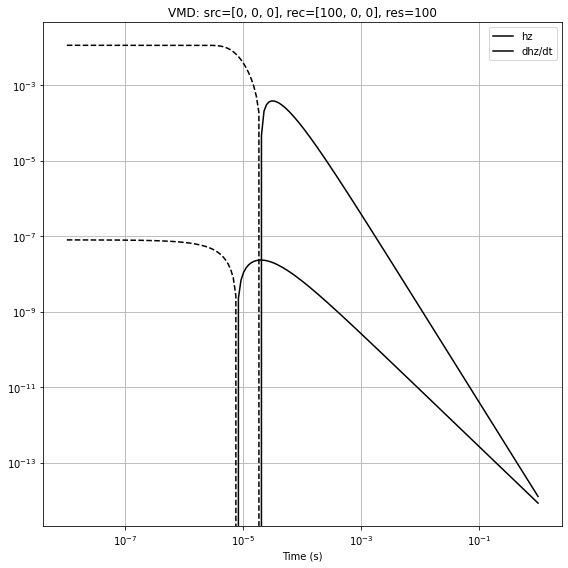

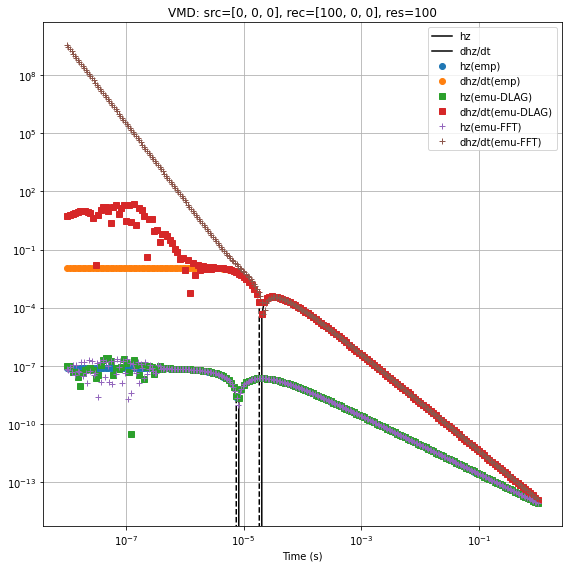

In [6]:
plt.figure(figsize=(8, 8))
plt.title(f'{emsrc_name}: src={src[:3]}, rec={rec[:3]}, res={res[1]}')

plt.plot(time_dlag, thz_ana, 'k-', label=r'hz')
plt.plot(time_dlag, -thz_ana, 'k--')
plt.plot(time_dlag_dt, thzdt_ana, 'k-', label=r'dhz/dt')
plt.plot(time_dlag_dt, -thzdt_ana, 'k--')

plt.xscale('log')
plt.yscale('log')
# plt.xlim([1e-1, 1e5])
# plt.ylim([1e-12, 1e-6])
plt.xlabel('Time (s)')

plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8, 8))
plt.title(f'{emsrc_name}: src={src[:3]}, rec={rec[:3]}, res={res[1]}')

plt.plot(time_dlag, thz_ana, 'k-', label=r'hz')
plt.plot(time_dlag, -thz_ana, 'k--')
plt.plot(time_dlag_dt, thzdt_ana, 'k-', label=r'dhz/dt')
plt.plot(time_dlag_dt, -thzdt_ana, 'k--')

plt.plot(time_dlag, thz_emp, 'C0o', label=r'hz(emp)')
plt.plot(time_dlag, -thz_emp, 'C0o')
plt.plot(time_dlag_dt, thzdt_emp, 'C1o', label=r'dhz/dt(emp)')
plt.plot(time_dlag_dt, -thzdt_emp, 'C1o')

plt.plot(time_dlag, thz_dlag_emu, 'C2s', label=r'hz(emu-DLAG)')
plt.plot(time_dlag, -thz_dlag_emu, 'C2s')
plt.plot(time_dlag_dt, thzdt_dlag_emu, 'C3s', label=r'dhz/dt(emu-DLAG)')
plt.plot(time_dlag_dt, -thzdt_dlag_emu, 'C3s')

plt.plot(time, thz_emu, 'C4+', label=r'hz(emu-FFT)')
plt.plot(time, -thz_emu, 'C4+')
plt.plot(time, thzdt_emu, 'C5+', label=r'dhz/dt(emu-FFT)')
plt.plot(time, -thzdt_emu, 'C5+')

plt.xscale('log')
plt.yscale('log')
# plt.xlim([1e-1, 1e5])
# plt.ylim([1e-12, 1e-6])
plt.xlabel('Time (s)')

plt.grid(True)
plt.legend()
plt.tight_layout()

# plt.figure(figsize=(8, 8))
# plt.title(f'{emsrc_name}: src={src[:3]}, rec={rec[:3]}, res={res[1]}')

# plt.plot(freq, rel_err_emp_re, 'o',label='Real(emp)')
# plt.plot(freq, rel_err_emp_re, 'o',label='Real(emp)')
# plt.plot(freq, rel_err_emu_re, 's',label='Real(emu)')
# plt.plot(freq, rel_err_emp_re, 's',label='Real(emp)')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1e-1, 1e5])
# # plt.ylim([1e-12, 1e-6])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Relative error (Hz)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()


plt.show()